# Blackjack environment

In [9]:
import gym
from IPython import display
import numpy as np
from collections import namedtuple
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
%matplotlib inline

EpisodeStats = namedtuple('Stats', ['episode_lengths', 'episode_rewards'])


def plot_value_function(V, title = "Value Function"):
    '''
    Plots the value function as a surface plot.
    '''
    min_x = 11 # min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize = (20, 10))
        ax = fig.add_subplot(111, projection = '3d')
        surf = ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1,
                               cmap = matplotlib.cm.coolwarm, vmin = -1.0, vmax = 1.0)
        ax.set_xlabel('Player Sum', fontsize=18)
        ax.set_ylabel('Dealer Showing', fontsize=18)
        ax.set_zlabel('Value', fontsize=18)
        ax.set_title(title, fontsize=22)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        ax.zaxis.set_tick_params(labelsize=12)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))


In [10]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (1998).
    http://incompleteideas.net/sutton/book/the-book.html
    """
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

# Monte Carlo Policy Evaluation

We begin by considering Monte Carlo methods for learning the state-value function for a given polcy. Recall that the value of a state is the expected return -- expected cumulative future discounted reward -- starting from the state. An obvious way to estimate it from experience, then, is simply to average the returns observed after visits to that state. As more return are observed, the average should converge to the expected value. This idea underlies all Monte Carlo methods.

In [11]:
def mc_prediction(policy, env, num_episodes, discount_factor = 1.0):
    '''
    Monte Carlo prediction algorithm. 
    Calculates the value function for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    '''
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    
    for i_episode in range(num_episodes):
        observation = env.reset()
        
        episodes = []
        for i in range(100):
            action = policy(observation)
            next_observation, reward, done, _ = env.step(action)
            episodes.append((observation, action, reward))
            if done:
                break
            observation = next_observation
        
        # obtain unique observation set
        observations = set([x[0] for x in episodes])
        for i, observation in enumerate(observations):
            # first occurence of the observation
            idx = episodes.index([episode for episode in episodes if episode[0] == observation][0])
            
            Q = sum([episode[2] * discount_factor ** i for episode in episodes[idx:]])
            
            returns_sum[observation] += Q
            returns_count[observation] += 1.0
            
            V[observation] = returns_sum[observation] / returns_count[observation]
                
    return V

In [12]:
env = gym.make('Blackjack-v0')

# A policy that sticks if the player score is >= 20 and hits otherwise.
def sample_policy(observation):
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

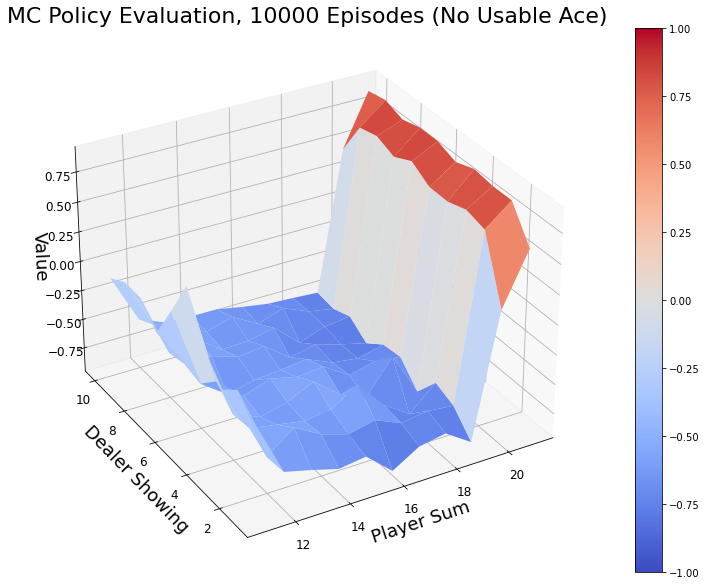

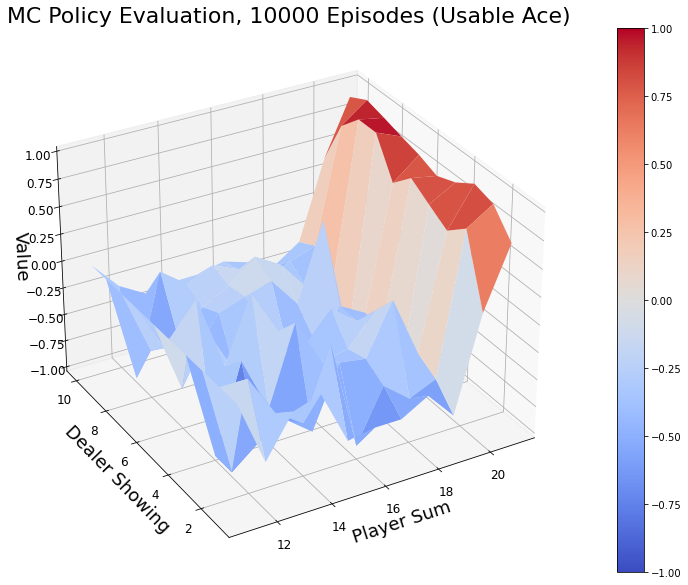

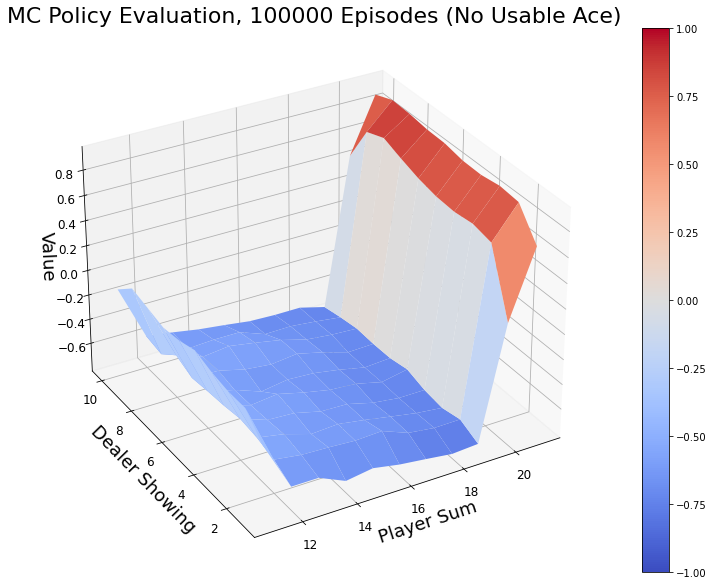

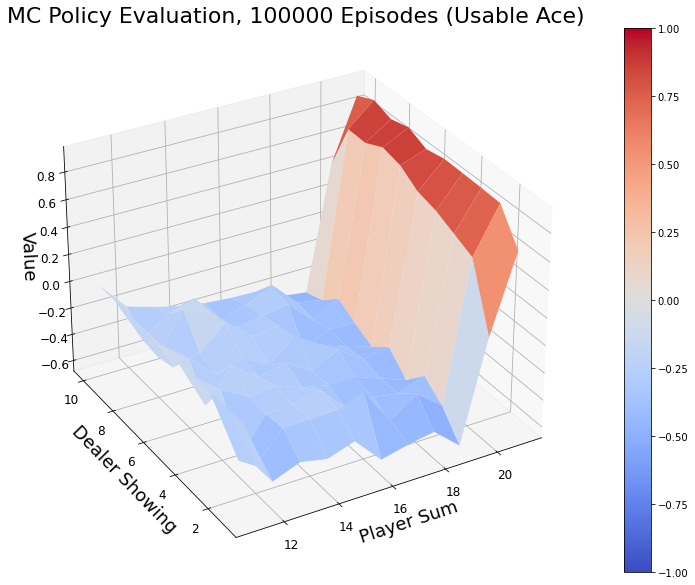

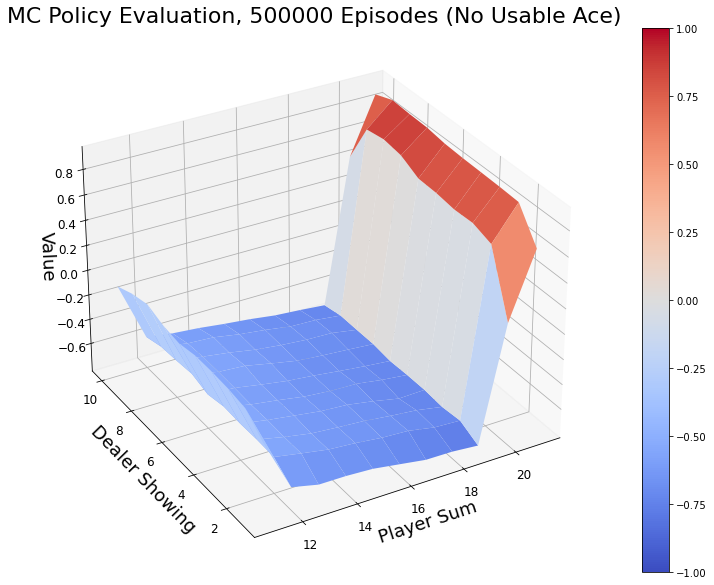

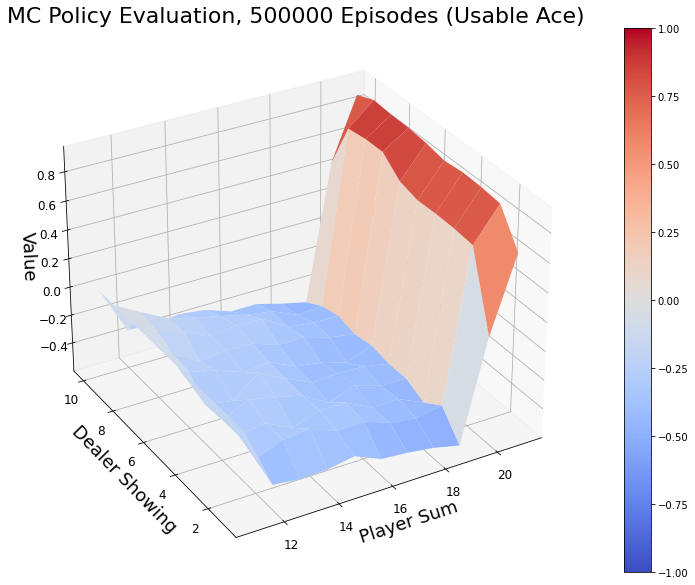

In [13]:
V_10k = mc_prediction(sample_policy, env, num_episodes = 10000)
plot_value_function(V_10k, title = 'MC Policy Evaluation, 10000 Episodes')

V_100k = mc_prediction(sample_policy, env, num_episodes = 100000)
plot_value_function(V_100k, title = 'MC Policy Evaluation, 100000 Episodes')

V_500k = mc_prediction(sample_policy, env, num_episodes = 500000)
plot_value_function(V_500k, title = 'MC Policy Evaluation, 500000 Episodes')

# Blackjack Playground

In [14]:
def print_observation(observation):
    score, dealer_score, usable_ace = observation
    print("Player Score: {} (Usable Ace: {}), Dealer Score: {}".format(
          score, usable_ace, dealer_score))

def strategy(observation):
    score, dealer_score, usable_ace = observation
    # Stick (action 0) if the score is > 20, hit (action 1) otherwise
    return 0 if score >= 20 else 1

for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        print_observation(observation)
        action = strategy(observation)
        print("Taking action: {}".format( ["Stick", "Hit"][action]))
        observation, reward, done, _ = env.step(action)
        if done:
            print_observation(observation)
            print("Game end. Reward: {}\n".format(float(reward)))
            break

Player Score: 17 (Usable Ace: False), Dealer Score: 10
Taking action: Hit
Player Score: 26 (Usable Ace: False), Dealer Score: 10
Game end. Reward: -1.0

Player Score: 15 (Usable Ace: False), Dealer Score: 10
Taking action: Hit
Player Score: 21 (Usable Ace: False), Dealer Score: 10
Taking action: Stick
Player Score: 21 (Usable Ace: False), Dealer Score: 10
Game end. Reward: 1.0

Player Score: 14 (Usable Ace: False), Dealer Score: 10
Taking action: Hit
Player Score: 24 (Usable Ace: False), Dealer Score: 10
Game end. Reward: -1.0

Player Score: 21 (Usable Ace: True), Dealer Score: 1
Taking action: Stick
Player Score: 21 (Usable Ace: True), Dealer Score: 1
Game end. Reward: 1.0

Player Score: 17 (Usable Ace: True), Dealer Score: 10
Taking action: Hit
Player Score: 15 (Usable Ace: False), Dealer Score: 10
Taking action: Hit
Player Score: 21 (Usable Ace: False), Dealer Score: 10
Taking action: Stick
Player Score: 21 (Usable Ace: False), Dealer Score: 10
Game end. Reward: 1.0

Player Score: 1

# On-Policy Monte Carlo Control

In on-policy control methods the policy is generally soft, meaning that π(s,a)>0
for all s∈S and all s∈A(s). There are many possible variations on on-policy methods. One possibility is to gradually shift the policy toward a deterministic optimal policy. The on-policy method we present in this section use ϵ-greedy policies, meaning that most of the time they choose an action that has maximum estimated action value, but with propability ϵ they instead select an action at random. That is, all nongreedy actions are gievn the minimal propability of selection, ϵ|A(s)|, and the remaining bulk of the probability, 1−ϵ+ϵ|A(s)|, is given to the greedy action.

In [15]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    '''
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    '''
    def policy_fn(observation):
        # Implement this!
        props = np.ones(nA, dtype = float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        props[best_action] += 1. - epsilon
        return props
        
    return policy_fn

In [16]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor = 1.0, epsilon = 0.1):
    '''
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    '''
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    for i_episode in range(num_episodes):
        observation = env.reset()
        
        episodes = []
        for i in range(100):
            props = policy(observation)
            action = np.random.choice(np.arange(len(props)), p = props)
            next_observation, reward, done, _ = env.step(action)
            episodes.append((observation, action, reward))
            
            if done:
            observation = next_observation
        
        # find the unique observation
        pairs = set([(episode[0], episode[1]) for episode in episodes])
        for (observation, action) in pairs:
            pair = (observation, action)
            # find the first occurence of the observation
            idx = episodes.index([episode for episode in episodes if episode[0] == observation and episode[1] == action][0])
            V = sum([reward[2] * discount_factor ** i for i, reward in enumerate(episodes[idx:])])
            
            returns_sum[pair] += V
            returns_count[pair] += 1.
            
            Q[observation][action] = returns_sum[pair] / returns_count[pair]
    return Q, policy

[206086.  42403. 251511.]


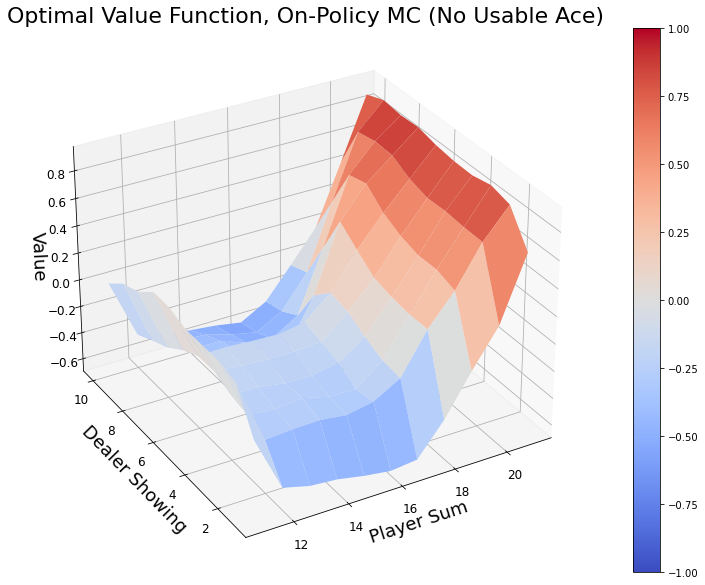

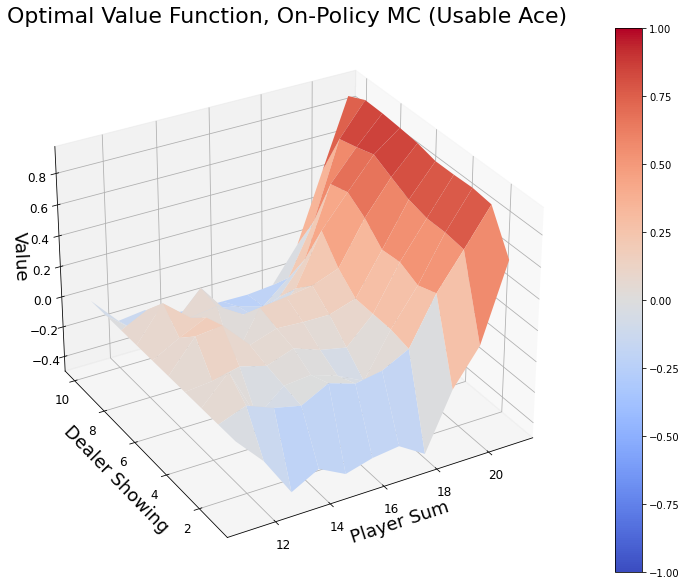

[14947.  2313. 32740.]


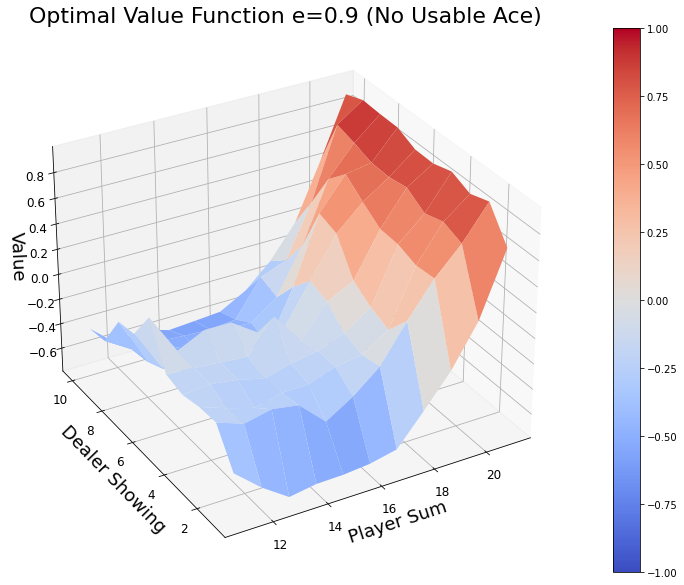

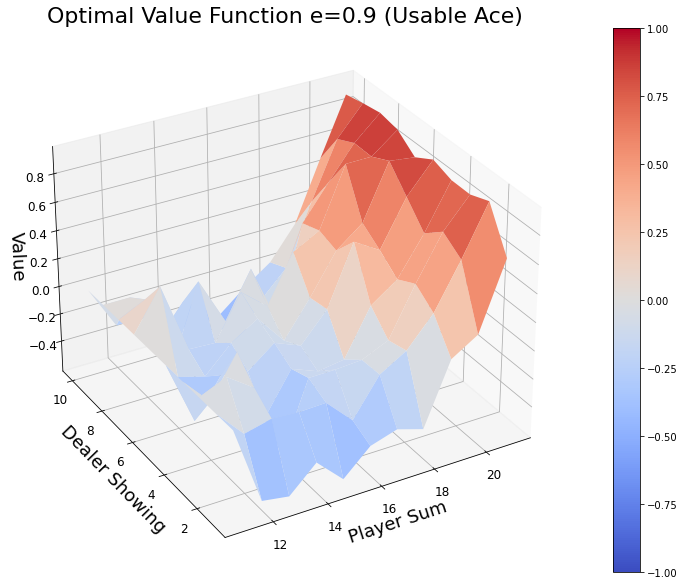

In [17]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes = 500000, epsilon = 0.1)

# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plot_value_function(V, title = 'Optimal Value Function, On-Policy MC')

Q1, policy1 = mc_control_epsilon_greedy(env, num_episodes = 50000, epsilon = 0.9)

# For plotting: Create value function from action-value function
# by picking the best action at each state
V1 = defaultdict(float)
for state, actions in Q1.items():
    action_value = np.max(actions)
    V1[state] = action_value
plot_value_function(V1, title = 'Optimal Value Function e=0.9')

# Off-Policy Monte Carlo with weighted importance sampling

Recall that the distinguishing feature of on-policy methods is that they estimate the value of a policy while using it for control. In off-policy method, these functinos are separated. The policy used to generate behavior, called the bahavior policy, may in fact by unrelated to the policy that is evaluated and improved, called the estimation policy. An advantage of this separation is that the estimation policy may be determinisitic (e.g. greedy), while the behavior policy can continue to sample all possible actions.

Off-Policy Monte Carlo with weighted importance sampleing

In [18]:
def create_random_policy(nA):
    '''
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    '''
    A = np.ones(nA, dtype = float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [19]:
def create_greedy_policy(Q):
    '''
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    '''
    
    def policy_fn(observation):
        # Implement this!
        props = Q[observation]
        best_action = np.argmax(props)
        A = np.zeros((len(props)), dtype = float)
        A[best_action] = 1.
        return A
    return policy_fn

In [20]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor = 1.0):
    '''
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    '''
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    D = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    # Implement this!
    for i_episode in range(num_episodes):
        observation = env.reset()
        
        episodes = []
        for i in range(100):
            props = behavior_policy(observation)
            action = np.random.choice(np.arange(len(props)), p = props)
            next_observation, reward, done, _ = env.step(action)
            episodes.append((observation, action, reward))
            if done:
                break
            observation = next_observation
        
        pairs = set([(episode[0], episode[1]) for episode in episodes])
        for (observation, action) in pairs:
            pair = (observation, action)
            
            # find the first occurence of this pair in episodes
            idx = episodes.index([episode for episode in episodes if episode[0] == observation and episode[1] == action][0])
            
            V = sum([episode[2] * discount_factor ** i for episode in episodes[idx:]])
            
            w = np.product([1. / behavior_policy(episode[0])[episode[1]] for episode in episodes[idx:]])
            
            N[observation][action] += w * V
            D[observation][action] += w
            
            Q[observation][action] = N[observation][action] / D[observation][action]
        
    return Q, target_policy

In [21]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes = 700000, behavior_policy = random_policy)

# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plot_value_function(V, title = 'Optimal Value Function, Off-Policy MC')

KeyboardInterrupt: 

# Reference

1. Render gym in python notebook https://stackoverflow.com/questions/40195740/how-to-run-openai-gym-render-over-a-server/40579087
2. blackjack https://applenob.github.io/black_jack.html
3. Monte Carlo Policy Evaluation http://www.incompleteideas.net/book/ebook/node51.html
4. Reinforcement learning https://github.com/dennybritz/reinforcement-learning
5. On-Policy Monte Carlo Control http://www.incompleteideas.net/book/ebook/node54.html
6. Off-Policy Monte Carlo Control http://www.incompleteideas.net/book/ebook/node56.html


# Playing the Dealer

In [60]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes = 5000000, epsilon = 0.1)
Q1, policy1 = mc_control_importance_sampling(env, num_episodes = 5000000, behavior_policy = random_policy)

[2073790.  431715. 2494495.]


In [61]:
def print_observation(observation):
    score, dealer_score, usable_ace = observation
    print("Player Score: {} (Usable Ace: {}), Dealer Score: {}".format(
          score, usable_ace, dealer_score))

def strategy(observation, Q):
    score, dealer_score, usable_ace = observation

    return np.argmax(Q[observation], axis=0)

def strategyOG(observation):
    score, dealer_score, usable_ace = observation
    # Stick (action 0) if the score is > 20, hit (action 1) otherwise
    return 0 if score >= 20 else 1

def play(Q, b):    
    result = np.zeros(3)  # player [win, draw, lose]
    for i_episode in range(100000):
        observation = env.reset()

        for t in range(100):
            #print_observation(observation)
            if b:
                action = strategy(observation, Q)
            else:
                action = strategyOG(observation)
            #print(Q)
            #print(action)
            #print("Taking action: {}".format( ["Stick", "Hit"][action]))
            observation, reward, done, _ = env.step(action)
            if done:
                if reward == 1:
                    result[0] += 1
                elif reward == 0:
                    result[1] += 1
                else:
                    result[2] += 1                
                #print_observation(observation)
                #print("Game end. Reward: {}\n".format(float(reward)))

                break
    return result
#print(result)
print(play(Q, True)) # On-policy
print(play(Q1, True)) # Off-policy
print(play(Q, False)) # OG policy

[43347.  9183. 47470.]
[41577.  7539. 50884.]
[29315.  5865. 64820.]
